# preprocess

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

In [4]:
import pandas as pd
train_xy = pd.read_csv("./train_xy_poly45_oversample.csv")
print(train_xy.shape)
X = train_xy.drop("y",axis=1).fillna(-1)
y = train_xy.y

(25061, 206)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y,random_state=222)
sfk = StratifiedKFold(n_splits=3,shuffle=True,random_state=111)

# define metrics

In [6]:
import itertools
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,confusion_matrix,auc

## confusion matrix

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

## learning_curve

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
                    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## model evaluation info

In [9]:
def eval_info(model,test_y,y_pred_prob,
                  cm,classes=y.unique(),normalize=False):
    print("------%s classification_report------\n" % model.__class__.__name__,
          classification_report(test_y,y_pred))
    
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    print("auc:",roc_auc_score(test_y,y_pred_prob))
#     print("auc(y_pred):",roc_auc_score(test_y,y_pred))
    fpr, tpr, thresholds = roc_curve(test_y,y_pred_prob,pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label='ROC curve(%f)' % auc(fpr, tpr),color='r')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',label='Luck')
    plt.title("%s ROC" % model.__class__.__name__)

# single model

## logistic

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

best score: 0.853605 
 best model: LogisticRegression(C=1.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
------LogisticRegression classification_report------
              precision    recall  f1-score   support

          0       0.82      0.78      0.80      3542
          1       0.73      0.78      0.76      2724

avg / total       0.78      0.78      0.78      6266

auc: 0.8581778465421446
train_score: 0.7879540295119183 
 test_score: 0.7810405362272582
logistic model parameters shape: (1, 205) 
 count of non-zero elements: 172


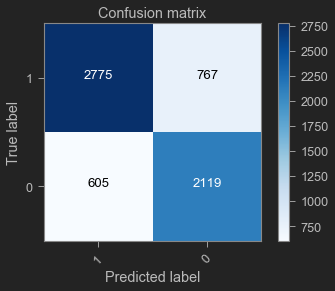

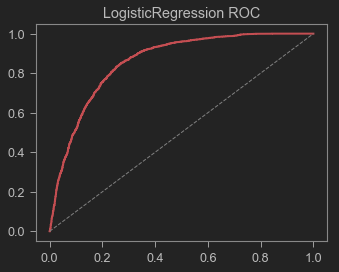

In [39]:
param_grid =  {
            'penalty':['l1'],#'l2'],
            'C':[1.7],
#             'solver':['newton-cg','lbfgs','sag'],
            'solver':['liblinear'],#'saga',],
#             'max_iter':[350],
#             'class_weight':['balanced',None],
            'random_state':[666],  
#             'fit_intercept':[False],
}
# param_grid =  {
#             'penalty':['l1'],#,'l2'],
#             'C':[0.1],
# #             'solver':['newton-cg','lbfgs','sag'],
#             'solver':['saga'],#,'liblinear',],
#             'max_iter':[350],
#             'class_weight':['balanced'],
#             'random_state':[666],  
# #             'fit_intercept':[False],
# }
LR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='roc_auc')
LR.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (LR.best_score_, LR.best_estimator_))

LR_best = LR.best_estimator_
y_pred =LR_best.predict(test_x)
y_pred_prob = LR_best.predict_proba(test_x)[:,1]
train_score = LR_best.score(train_x,train_y)
test_score = LR_best.score(test_x,test_y)
cm = confusion_matrix(test_y,y_pred)

eval_info(LR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

print("logistic model parameters shape:",LR_best.coef_.shape,"\n",
     "count of non-zero elements:",np.count_nonzero(LR_best.coef_))

In [10]:
import pickle
with open("../best_models/LR_pkl.txt",'rb') as lr:
    lr = pickle.load(lr)
lr

LogisticRegression(C=0.035, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=350,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
auc: 0.8328911160295016
train_score: 0.7121565810738014 
test_score: 0.7077834635065985

In [70]:
# save model
import pickle
with open("./best_models/LR_pkl.txt",'wb') as f:
    pickle.dump(LR_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
LR_cv_auc = cross_val_score(LR_best,X,y,cv=5,scoring="roc_auc")
print("best_LR_cv_auc",LR_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best_LR_cv_auc [0.80543747 0.82687873 0.80942799 0.79248482 0.81046117]


F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [71]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = LR_best.predict(test_all)
y_pred_prob = LR_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_LR.csv",header=True)

0    7900
1    2100
dtype: int64


## Decision Tree

best score: 0.962807 
 best model: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=233,
            splitter='best')
------DecisionTreeClassifier classification_report------
              precision    recall  f1-score   support

          0       0.94      0.93      0.93      3542
          1       0.91      0.92      0.91      2724

avg / total       0.92      0.92      0.92      6266

auc: 0.9696015653566888
train_score: 0.9460130533484676 
 test_score: 0.9243536546441111


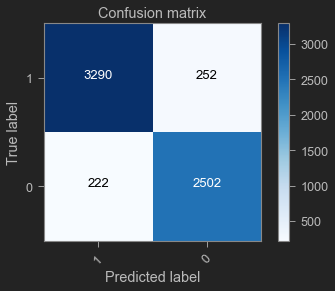

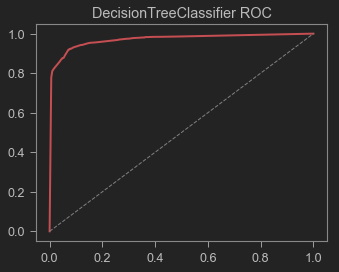

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"criterion":['entropy'],
               "max_depth":[10],
                'max_features':[0.9],
#               "min_impurity_decrease":[0],
#              "min_samples_split":[2],
              "min_samples_leaf":[3], # 样本量不大不需管
#               "max_leaf_nodes":[19],
#               "class_weight":["balanced",None],
#               'min_weight_fraction_leaf':[0.04],
              'random_state':[233],
             }
DT = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=sfk,scoring='roc_auc')
DT.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (DT.best_score_, DT.best_estimator_))

DT_best = DT.best_estimator_
train_score = DT_best.score(train_x,train_y)
test_score = DT_best.score(test_x,test_y)
y_pred = DT_best.predict(test_x)
y_pred_prob = DT_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(DT_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [74]:
# save model
import pickle
with open("./best_models/DT_pkl.txt",'wb') as f:
    pickle.dump(DT_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
DT_cv_auc = cross_val_score(DT_best,X,y,cv=5,scoring="roc_auc")
print("best_DT_cv_auc:",DT_cv_auc)

best_DT_cv_auc: [0.726542   0.73438309 0.76924593 0.75697398 0.77645116]


In [75]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = DT_best.predict(test_all)
y_pred_prob = DT_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_DT.csv",header=True)

0    6513
1    3487
dtype: int64


## random forest

best score: 0.993962 
 best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=False, random_state=222, verbose=0, warm_start=False)
------RandomForestClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      1.00      0.98      3542
          1       0.99      0.95      0.97      2724

avg / total       0.98      0.97      0.97      6266

auc: 0.9947337426029247
train_score: 0.9999290578887627 
 test_score: 0.9746249601021385


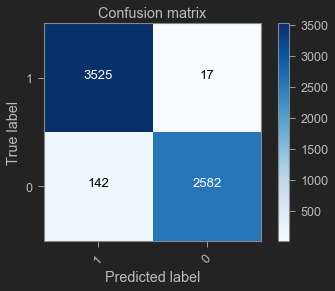

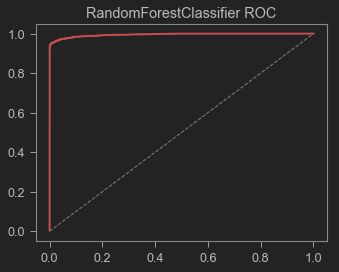

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
            'criterion':['entropy'],
            'n_estimators':[180],#140
#             'class_weight':["balanced",None],
#             'max_features':["sqrt"],
            'max_depth':[18],#4
#              "min_samples_split":[], # 样本量不大不需管
#               "min_samples_leaf":[], # 样本量不大不需管
#             "max_leaf_nodes":[20],
#             'min_impurity_decrease':[0],
#             'n_jobs':[-1],
            'random_state':[222],
             }

RF = GridSearchCV(RandomForestClassifier(),param_grid,cv=sfk,scoring='roc_auc')
RF.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (RF.best_score_, RF.best_estimator_))
RF_best = RF.best_estimator_
train_score = RF_best.score(train_x,train_y)
test_score = RF_best.score(test_x,test_y)
y_pred = RF_best.predict(test_x)
y_pred_prob = RF_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(RF_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [ ]:
auc: 0.8323788444993203
train_score: 0.7401687915245106 
test_score: 0.7382170751413951

In [77]:
# save model
import pickle
with open("./best_models/RF_pkl.txt",'wb') as f:
    pickle.dump(RF_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
RF_cv_auc = cross_val_score(RF_best,X,y,cv=5,scoring="roc_auc")
print("best_RF_cv_auc:",RF_cv_auc)

best_RF_cv_auc: [0.78937931 0.81284831 0.8215067  0.77712105 0.80834714]


In [78]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = RF_best.predict(test_all)
y_pred_prob = RF_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_RF.csv",header=True)

0    7957
1    2043
dtype: int64


## extra tree

best score: 0.998096 
 best model: ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=40, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=350, n_jobs=1, oob_score=False, random_state=222,
           verbose=0, warm_start=False)
------ExtraTreesClassifier classification_report------
              precision    recall  f1-score   support

          0       0.99      0.99      0.99      3542
          1       0.99      0.98      0.99      2724

avg / total       0.99      0.99      0.99      6266

auc: 0.9992370762098783
train_score: 1.0 
 test_score: 0.9886690073412066


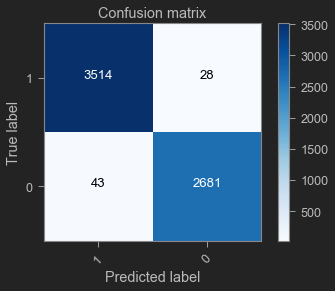

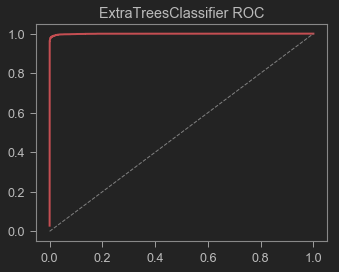

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {
            'criterion':['entropy'],
            'n_estimators':[350], #150
            'class_weight':["balanced"],
#             'max_features':["sqrt"],
            'max_depth':[40], #5
#             'bootstrap':[True,False],
#              "min_samples_split":[], # 样本量不大不需管
#               "min_samples_leaf":[], # 样本量不大不需管
#             "max_leaf_nodes":[13,15,20],
#             'min_impurity_decrease':[0],
#             'n_jobs':[-1],
            'random_state':[222],
             }

ET = GridSearchCV(ExtraTreesClassifier(),param_grid,cv=sfk,scoring='roc_auc')
ET.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (ET.best_score_,ET.best_estimator_))

ET_best = ET.best_estimator_
train_score = ET_best.score(train_x,train_y)
test_score = ET_best.score(test_x,test_y)
y_pred = ET_best.predict(test_x)
y_pred_prob = ET_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(ET_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [ ]:
auc: 0.8341717948549549
train_score: 0.6909678577841624 
test_score: 0.680312415836251

In [80]:
# save model
import pickle
with open("./best_models/ET_pkl.txt",'wb') as f:
    pickle.dump(ET_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
ET_cv_auc = cross_val_score(ET_best,X,y,cv=5,scoring="roc_auc")
print("best_ET_cv_auc:",ET_cv_auc)

best_ET_cv_auc: [0.80135003 0.81024346 0.81221063 0.78116103 0.79102651]


In [81]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = ET_best.predict(test_all)
y_pred_prob = ET_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_ET.csv",header=True)

0    7964
1    2036
dtype: int64


## SVM

In [52]:
# svm_train_xy = pd.read_csv("F:./resample data/under_resample1.csv",index_col=['cust_id'])
# svm_y = svm_train_xy.y
# svm_X = svm_train_xy.drop('y',axis=1)
# svm_train_x,svm_test_x,svm_train_y,svm_test_y = train_test_split(svm_X,svm_y,stratify=svm_y)
# sfk = StratifiedKFold(n_splits=3)

best score: 0.976518 
 best model: SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03, kernel='rbf',
  max_iter=-1, probability=True, random_state=520, shrinking=True,
  tol=0.001, verbose=False)
------SVC classification_report------
              precision    recall  f1-score   support

          0       0.88      0.99      0.93      3542
          1       0.99      0.82      0.90      2724

avg / total       0.93      0.92      0.92      6266

auc: 0.9848625804381406
train_score: 0.9997162315550511 
 test_score: 0.9194063198212575


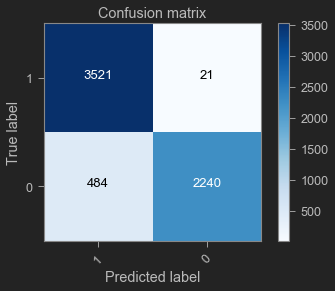

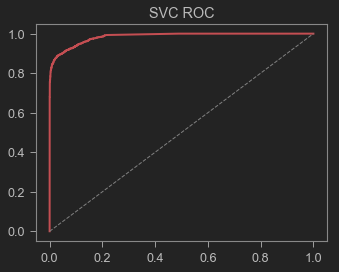

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {
            'C':[1.5],
            'kernel':['rbf'],
#             'class_weight':["balanced",None],
            'gamma':[0.03],
#             'shrinking':[True],
            'probability':[True],
            'random_state':[520],
             }

SVC = GridSearchCV(SVC(),param_grid,cv=sfk,scoring='roc_auc')
SVC.fit(train_x,train_y)
print("best score: %f \n best model: %s" % (SVC.best_score_, SVC.best_estimator_))
SVC_best = SVC.best_estimator_
train_score = SVC_best.score(train_x,train_y)
test_score = SVC_best.score(test_x,test_y)
y_pred = SVC_best.predict(test_x)
y_pred_prob = SVC_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(SVC_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [83]:
# save model
import pickle
with open("./best_models/SVM_pkl.txt",'wb') as f:
    pickle.dump(SVC_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
SVC_cv_auc = cross_val_score(SVC_best,X,y,cv=5,scoring="roc_auc")
print("best_SVC_cv_auc",SVC_cv_auc)

best_SVC_cv_auc [0.73086348 0.72610346 0.71560673 0.68811788 0.753077  ]


## xgb-sklearn

best score: 0.990040 
 best model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=18, min_child_weight=8, missing=-1,
       n_estimators=150, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=7,
       reg_lambda=8, scale_pos_weight=1.299885788872573, seed=None,
       silent=True, subsample=0.8)


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------XGBClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.97      3542
          1       0.99      0.94      0.96      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.9895335064603406
train_score: 0.9805618615209989 
 test_score: 0.9701563996169805


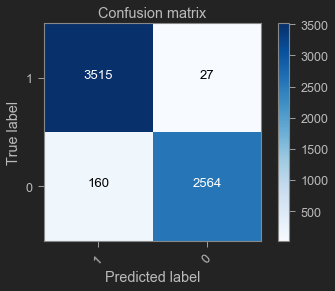

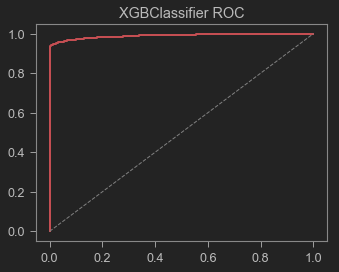

In [61]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'booster':['gbtree'],
    'objective': ['binary:logistic'],
    'n_estimators':[150],
    'max_depth':[18],
    'learning_rate':[0.1],
    'min_child_weight':[8],
    'gamma':[0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'reg_alpha': [7],
    'reg_lambda': [8],
    'scale_pos_weight':[float(len(train_y)-sum(train_y))/float(sum(train_y))],
    'random_state':[0],
#     'n_jobs': [-1],
    'missing': [-1],
    'silent':[True],
}

XGB = GridSearchCV(XGBClassifier(),param_grid,cv=sfk,scoring='roc_auc')#,iid=False)
XGB.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (XGB.best_score_, XGB.best_estimator_))

XGB_best = XGB.best_estimator_
y_pred = XGB_best.predict(test_x)
y_pred_prob = XGB_best.predict_proba(test_x)[:,1]
train_score = XGB_best.score(train_x,train_y)
test_score = XGB_best.score(test_x,test_y)
cm = confusion_matrix(test_y,y_pred)

eval_info(XGB_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [ ]:
auc: 0.835688906694338
train_score: 0.7562398994433471 
test_score: 0.7471047670347428

In [85]:
# save model
import pickle
with open("./best_models/XGB_pkl.txt",'wb') as f:
    pickle.dump(XGB_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
XGB_cv_auc = cross_val_score(XGB_best,X,y,cv=5,scoring="roc_auc")
print("best_XGB_cv_auc:",XGB_cv_auc)

best_XGB_cv_auc: [0.81029226 0.83021532 0.82612124 0.79244617 0.82930066]


In [86]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = XGB_best.predict(test_all)
y_pred_prob = XGB_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_XGB.csv",header=True)

0    9004
1     996
dtype: int64


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## xgb:raw interface

[0]	train-auc:0.951587
Will train until train-auc hasn't improved in 340 rounds.
[60]	train-auc:0.994907
[120]	train-auc:0.996482
[180]	train-auc:0.997342
[240]	train-auc:0.997945
[300]	train-auc:0.998322
[360]	train-auc:0.998611
[420]	train-auc:0.998803
[480]	train-auc:0.998954
[540]	train-auc:0.999103
[599]	train-auc:0.999197
------Booster classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.97      3542
          1       0.99      0.94      0.96      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.989438257586122


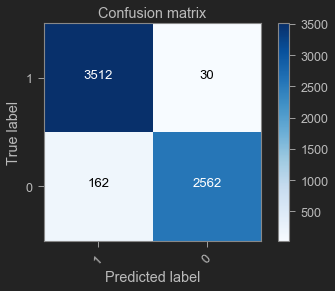

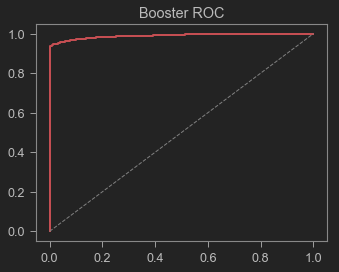

In [66]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest = xgb.DMatrix(test_x)

params = {
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
            'eval_metric': 'auc',
            'gamma':0.1,#0.05,
            'max_depth':18,#3,
            'alpha':10,#7,
            'lambda':8,#5,
            'subsample':0.8,
            'colsample_bytree':0.7,
#             'min_child_weight':5, 
            'eta': 0.1,#0.02,
            'seed':0,
            'silent':1,
            'missing':-1,
        }
# xgb_cv = xgb.cv(params, dtrain, 
#            num_boost_round=1000, 
#            nfold=3, stratified=True,#folds=sfk
#            metrics='auc', maximize=True, 
#            early_stopping_rounds=500, 
#            as_pandas=True, verbose_eval=1, 
#            show_stdv=False, seed=0, shuffle=True)
xgb_model = xgb.train(params,dtrain,num_boost_round=600,early_stopping_rounds=340,
                       evals=[(dtrain,"train")],verbose_eval=60,maximize=True)
y_pred_prob = xgb_model.predict(dtest,ntree_limit=338)
y_pred = np.where(y_pred_prob>0.5,1,0)

cm = confusion_matrix(test_y,y_pred)
eval_info(xgb_model,test_y,y_pred_prob,cm)

# xgb.plot_importance(xgb_model,max_num_features=20)
# plt.figure(figsize=(20,20))
# xgb.plot_tree(xgb_model,ax=plt,num_trees=5)

In [ ]:
auc: 0.9881798116331731

## GBDT

best score: 0.993673 
 best model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=15,
              max_features=0.7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=180,
              presort='auto', random_state=1, subsample=0.8, verbose=0,
              warm_start=False)
------GradientBoostingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      1.00      0.98      3542
          1       1.00      0.94      0.97      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.9941066961513236
train_score: 1.0 
 test_score: 0.9739865943185445


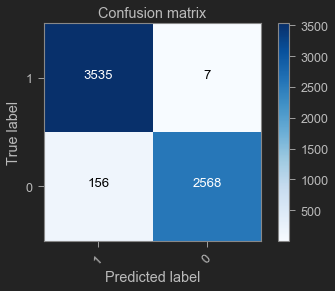

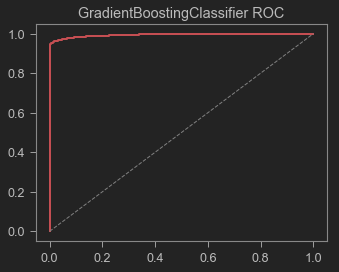

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
        'loss':['deviance'],
        'n_estimators':[180],
        'max_depth':[15],
        'learning_rate':[0.05],
#         'criterion':['friedman_mse'],#默认
        'subsample': [0.8],
        'max_features':[0.7],
#         "max_leaf_nodes":[8],
#         'min_impurity_decrease':[0],
        'random_state':[1],
}

GBDT = GridSearchCV(GradientBoostingClassifier(),param_grid,cv=sfk,scoring='roc_auc')
GBDT.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (GBDT.best_score_,GBDT.best_estimator_))

GBDT_best = GBDT.best_estimator_

train_score = GBDT_best.score(train_x,train_y)
test_score = GBDT_best.score(test_x,test_y)
y_pred = GBDT_best.predict(test_x)
y_pred_prob = GBDT_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(GBDT_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

In [88]:
# save model
import pickle
with open("./best_models/GBDT_pkl.txt",'wb') as f:
    pickle.dump(GBDT_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
GBDT_cv_auc = cross_val_score(GBDT_best,X,y,cv=5,scoring="roc_auc")
print("best_XGB_cv_auc:",GBDT_cv_auc)

best_XGB_cv_auc: [0.7978023  0.82175404 0.81778105 0.7931341  0.82255791]


In [89]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = GBDT_best.predict(test_all)
y_pred_prob = GBDT_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_GBDT.csv",header=True)

0    9995
1       5
dtype: int64


## MLP

best score: 0.987777 
 best model: MLPClassifier(activation='logistic', alpha=0.012, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=888,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
------MLPClassifier classification_report------
              precision    recall  f1-score   support

          0       0.99      0.95      0.97      3542
          1       0.94      0.98      0.96      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.9906380410115326
train_score: 0.9966657207718501 
 test_score: 0.9966657207718501


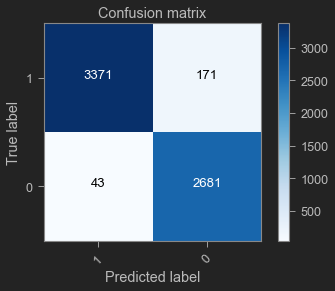

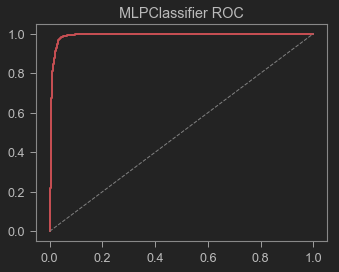

In [71]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'hidden_layer_sizes':[(400,)],
    'activation':['logistic'],#'relu'],
    'solver':['adam'],
#     'Note':
    'alpha':[0.012],
#     'batch_size':
    'learning_rate':['constant'],
#     'learning_rate_init':
#     'power_t':
#     'max_iter':[300],
#     'shuffle':
    'random_state':[888],
#     'tol':
#     'verbose':
#     'warm_start':
    'momentum':[0.9],
#     'nesterovs_momentum':
#     'early_stopping':[True],
#     'validation_fraction':
#     'beta_1':
#     'beta_2':
#     'epsilon':
}

MLP = GridSearchCV(MLPClassifier(),param_grid,cv=sfk,scoring='roc_auc')
MLP.fit(train_x,train_y)
print("best score: %f \n best model: %s" % (MLP.best_score_, MLP.best_estimator_))
MLP_best = MLP.best_estimator_
train_score = MLP_best.score(train_x,train_y)
test_score = MLP_best.score(train_x,train_y)
y_pred = MLP_best.predict(test_x)
y_pred_prob = MLP_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(MLP_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [68]:
# save model
# import pickle
# with open("./best_models/MLP_pkl.txt",'wb') as f:
#     pickle.dump(MLP_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
MLP_cv_auc = cross_val_score(MLP_best,X,y,cv=5,scoring="roc_auc")
print("best_MLP_cv_auc:",MLP_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


best_MLP_cv_auc: [0.80072592 0.78058131 0.80176028 0.74844443 0.75232209]


In [26]:
# predict
test_all = pd.read_csv("./test_all_poly45.csv",index_col=['cust_group','cust_id'])
y_pred = MLP_best.predict(test_all)
y_pred_prob = MLP_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("../predict/pred_result_MLP_poly45.csv",header=True)

0    9791
1     209
dtype: int64


# adaboost

In [89]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'base_estimator':[DT_best],#[RF_best],
#     'n_estimators':[700],#可能更高
#     'learning_rate':[0.1],
#     'random_state':[999],
# }

# ADAB = GridSearchCV(AdaBoostClassifier(),param_grid,cv=sfk,scoring="roc_auc")
# ADAB.fit(train_x,train_y)

# print("best score: %f \n best model: %s" % (ADAB.best_score_,ADAB.best_estimator_))

# ADAB_best = ADAB.best_estimator_
# train_score = ADAB_best.score(train_x,train_y)
# test_score = ADAB_best.score(test_x,test_y)
# y_pred = ADAB_best.predict(test_x)
# y_pred_prob = ADAB_best.predict_proba(test_x)[:,1]
# cm = confusion_matrix(test_y,y_pred)

# eval_info(ADAB_best,test_y,y_pred_prob,cm)
# print("train_score:",train_score,"\n","test_score:",test_score)

In [142]:
# save model
import pickle
with open("./best_models/ADAB_RF_pkl.txt",'wb') as f:
    pickle.dump(ADAB_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
ADAB_cv_auc = cross_val_score(ADAB_best,X,y,cv=5,scoring="roc_auc")
print("best_ADAB_cv_auc:",ADAB_cv_auc)

best_ADAB_cv_auc: [0.8104355  0.82646391 0.82957119 0.7907972  0.81782743]


In [143]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = ADAB_best.predict(test_all)
y_pred_prob = ADAB_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_ADAB_RF.csv",header=True)

0    9448
1     552
dtype: int64


# bagging XGB_best

------BaggingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.98      3542
          1       0.99      0.94      0.97      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.9896627505801994
train_score: 0.9783626560726447 
 test_score: 0.9714331311841685


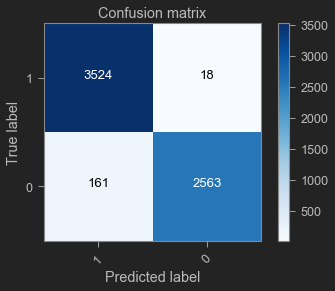

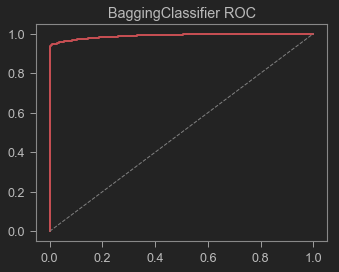

In [73]:
from sklearn.ensemble import BaggingClassifier

bagging_xgb = BaggingClassifier(XGB_best,n_estimators=10)
bagging_xgb.fit(train_x,train_y)

train_score =bagging_xgb.score(train_x,train_y)
test_score = bagging_xgb.score(test_x,test_y)
y_pred = bagging_xgb.predict(test_x)
y_pred_prob = bagging_xgb.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(bagging_xgb,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# bagging xgb:sklearn(vary params)

------XGBClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.98      3542
          1       0.99      0.94      0.97      2724

avg / total       0.97      0.97      0.97      6266

auc: 0.9897951040213059


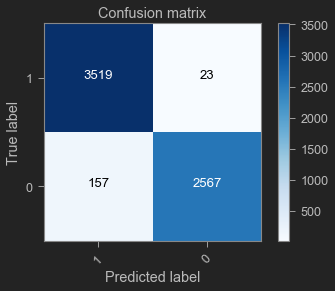

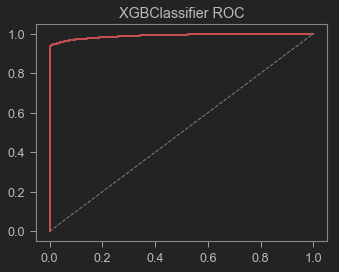

In [74]:
from sklearn.ensemble import BaggingClassifier

# n_estimators = [142,145,148] 
n_estimators = [180,245,200]
# max_depth = [2,3,4] 
max_depth = [9,10,15,20] 
learning_rate = np.linspace(0.045,0.055,10) 
min_child_weight= [5,4,6] 
gamma = np.linspace(0.045,0.055,10)
subsample = [0.7,0.75,0.8,0.85]
colsample_bytree = [0.6,0.65,0.7,0.75]
reg_alpha =[6,7,8,10]
reg_lambda = [4,5,6,8,9]
random_state = np.arange(1000,10000,100)

np.random.shuffle(n_estimators)
np.random.shuffle(max_depth)
np.random.shuffle(learning_rate)
np.random.shuffle(min_child_weight)
np.random.shuffle(gamma)
np.random.shuffle(subsample)
np.random.shuffle(colsample_bytree)
np.random.shuffle(reg_alpha)
np.random.shuffle(reg_lambda)
np.random.shuffle(random_state)

prob_df = pd.DataFrame([],index=test_x.index)
for i in range(30):
    param_grid = {
        'booster':'gbtree',
        'objective': 'binary:logistic',
        'n_estimators':n_estimators[i%3],
        'max_depth':max_depth[i%3],
        'learning_rate':learning_rate[i%10],
        'min_child_weight':min_child_weight[i%3],
        'gamma':gamma[i%10],
        'subsample':subsample[i%4],
        'colsample_bytree': colsample_bytree[i%4],
        'reg_alpha':reg_alpha[i%3],
        'reg_lambda': reg_lambda[i%3],
        'scale_pos_weight':float(len(train_y)-sum(train_y))/float(sum(train_y)),
        'random_state':random_state[i],
#     'n_jobs': [-1],
        'missing': -1,
        'silent':True,
    }

#     bagging_xgb = BaggingClassifier(XGBClassifier().set_params(**param_grid),n_estimators=10)
    # bagging_xgb = BaggingClassifier(XGB_best,n_estimators=10)
#     bagging_xgb.fit(train_x,train_y)
    xgb_ = XGBClassifier().set_params(**param_grid)
    xgb_.fit(train_x,train_y)
    y_prob = xgb_.predict_proba(test_x)[:,1]
    y_prob_s = pd.Series(y_prob,index=test_x.index)
    prob_df = pd.concat([prob_df,y_prob_s],axis=1)

y_pred_prob = prob_df.mean(axis=1)
y_pred = (y_pred_prob>0.5)*1

cm = confusion_matrix(test_y,y_pred)
eval_info(xgb_,test_y,y_pred_prob,cm)

# print( "train_score:",train_score,"\n","test_score:",test_score)

# bagging dt

best score: 0.990271 
 best model: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=0.9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=233,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.8, n_estimators=140, n_jobs=1, oob_score=False,
         random_state=777, verbose=0, warm_start=False)
------BaggingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.95      0.98      0.97      3542
          1       0.97      0.93      0.95      2724

avg / total       0.96      0.96      0.96      6266

auc: 0.9901456281699532
train_score: 0.9723325766174802 
 test_score: 0.9605809128630706


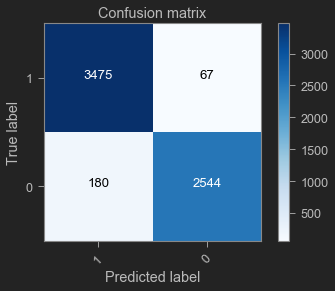

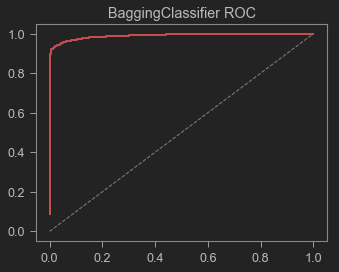

In [75]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'base_estimator':[DT_best],#LR_best,SVC_best,GBDT_best],
    'n_estimators':[140,200,250],
    'max_samples':[0.8],
    'max_features':[0.7],
    'random_state':[777],
}

BAGG = GridSearchCV(BaggingClassifier(),param_grid,cv=sfk,scoring="roc_auc")
BAGG.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (BAGG.best_score_,BAGG.best_estimator_))
BAGG_best = BAGG.best_estimator_
train_score = BAGG_best.score(train_x,train_y)
test_score = BAGG_best.score(test_x,test_y)
y_pred = BAGG_best.predict(test_x)
y_pred_prob = BAGG_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(BAGG_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# bagging lr

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best score: 0.793553 
 best model: BaggingClassifier(base_estimator=LogisticRegression(C=0.08, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=350,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='saga', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=777, verbose=0, warm_start=False)
------BaggingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.98      0.75      0.85      3541
          1       0.12      0.72      0.21       172

avg / total       0.94      0.75      0.82      3713

auc: 0.8180204645908724
train_score: 0.7475309750404022 
 test_score: 0.7460274710476703


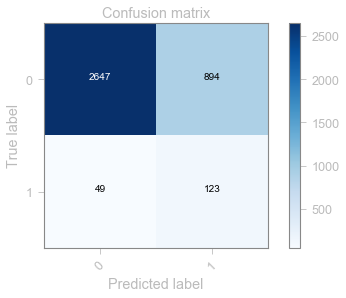

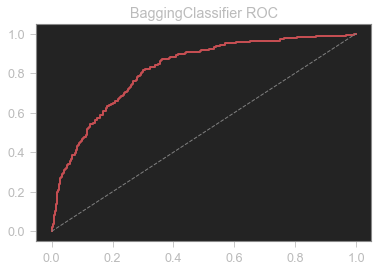

In [44]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'base_estimator':[LR_best],#SVC_best,GBDT_best],
#     'n_estimators':[80],
#     'max_samples':[0.8],
#     'max_features':[0.7],
    'random_state':[777],
}

BAGG = GridSearchCV(BaggingClassifier(),param_grid,cv=sfk,scoring="roc_auc")
BAGG.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (BAGG.best_score_,BAGG.best_estimator_))
BAGG_best = BAGG.best_estimator_
train_score = BAGG_best.score(train_x,train_y)
test_score = BAGG_best.score(test_x,test_y)
y_pred = BAGG_best.predict(test_x)
y_pred_prob = BAGG_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(BAGG_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# voting 

## voting1

best score: 0.998071 
 best model: VotingClassifier(estimators=[('lr', LogisticRegression(C=1.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=666, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('mlp', MLPClas...         presort='auto', random_state=1, subsample=0.8, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 6, 3, 4, 5, 6])


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------VotingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.97      0.99      0.98      3542
          1       0.99      0.96      0.97      2724

avg / total       0.98      0.98      0.98      6266

auc: 0.998876084013031
train_score: 1.0 
 test_score: 0.977976380466007


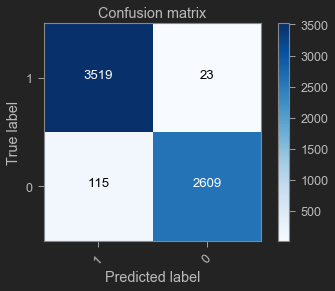

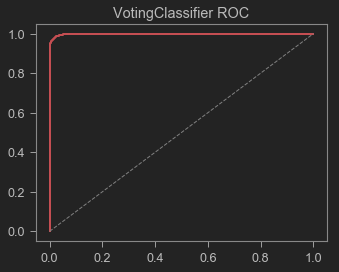

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
param_grid ={
    'voting':['soft'],
    'weights':[
#                [2,5,1,1,6,5],
               [1,6,3,4,5,6]
    ]
}

estimators = [ ('lr', LR_best),('mlp',MLP_best), 
               ('rf', RF_best),('et', ET_best) ,
               ('xgb',XGB_best),('gbdt',GBDT_best)
             ]

voting =GridSearchCV(VotingClassifier(estimators),param_grid,cv=sfk,scoring="roc_auc")
voting.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (voting.best_score_,voting.best_estimator_))
voting_best = voting.best_estimator_
train_score = voting_best.score(train_x,train_y)
test_score = voting_best.score(test_x,test_y)
y_pred = voting_best.predict(test_x)
y_pred_prob = voting_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(voting_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

In [27]:
# save model
import pickle
with open("../best_models/voting_pkl.txt",'wb') as f:
    pickle.dump(voting_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
voting_cv_auc = cross_val_score(voting_best,X,y,cv=5,scoring="roc_auc")
print("best_voting_cv_auc:",voting_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


best_voting_cv_auc: [0.81849015 0.82903785 0.82477372 0.80448108 0.82962014]


In [82]:
# predict
test_all = pd.read_csv("../another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
test_all['x_80.1'] = test_all['x_80']
from functools import reduce
for col in train_xy.columns[-6:]:
    cols = col.split()
    test_all[col] = test_all[cols].cumprod(1).iloc[:,-1]
test_all = test_all[train_xy.columns.drop('y')]
y_pred = voting_best.predict(test_all)
y_pred_prob = voting_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("../predict/pred_result_voting.csv",header=True)

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    9955
1      45
dtype: int64


## voting2

best score: 0.998331 
 best model: VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=18, min_child_weight=8, missing=-1,
       n_estimators=150, n_jobs=1, nthread=None,
       objective='binary:logisti...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 5, 2, 6, 6])


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------VotingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.97      1.00      0.98      3542
          1       0.99      0.96      0.98      2724

avg / total       0.98      0.98      0.98      6266

auc: 0.9990304099909539
train_score: 1.0 
 test_score: 0.9819661666134695


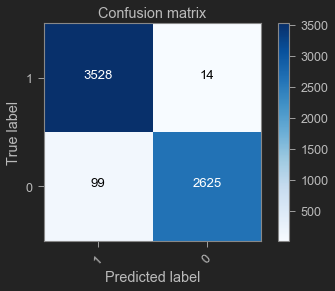

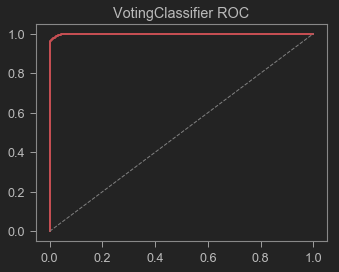

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
param_grid ={
    'voting':['soft'],
    'weights':[
#                [1,5,3,5,6],
               [1,5,2,6,6]
    ]
}

estimators = [ ('xgb', XGB_best),('gbdt',GBDT_best),('bagging_xgb', bagging_xgb),
              ('ADAB',ADAB_best),('mlp',MLP_best)
             ]

voting =GridSearchCV(VotingClassifier(estimators),param_grid,cv=sfk,scoring="roc_auc")
voting.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (voting.best_score_,voting.best_estimator_))
voting_best = voting.best_estimator_
train_score = voting_best.score(train_x,train_y)
test_score = voting_best.score(test_x,test_y)
y_pred = voting_best.predict(test_x)
y_pred_prob = voting_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(voting_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

## voting3

best score: 0.998400 
 best model: VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_w...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 3, 4, 2])


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------VotingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.97      1.00      0.98      3542
          1       0.99      0.96      0.98      2724

avg / total       0.98      0.98      0.98      6266

auc: 0.9991283536102538
train_score: 1.0 
 test_score: 0.9787743376954995


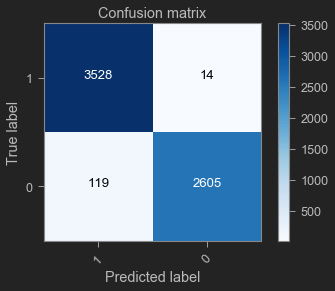

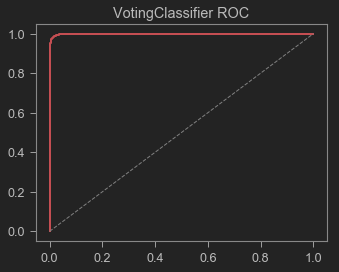

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
param_grid ={
    'voting':['soft'],
    'weights':[
               [1,3,4,2]
    ]
}

estimators = [ ('rf', RF_best),('et',ET_best),
              ('gbdt',GBDT_best),('mlp',MLP_best)
             ]

voting3 =GridSearchCV(VotingClassifier(estimators),param_grid,cv=sfk,scoring="roc_auc")
voting3.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (voting3.best_score_,voting3.best_estimator_))
voting_best = voting3.best_estimator_
train_score = voting3_best.score(train_x,train_y)
test_score = voting3_best.score(test_x,test_y)
y_pred = voting3_best.predict(test_x)
y_pred_prob = voting3_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(voting3_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

In [ ]:
# save model
import pickle
with open("../best_models/voting3_pkl.txt",'wb') as f:
    pickle.dump(voting_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
voting3_cv_auc = cross_val_score(voting_best,X,y,cv=5,scoring="roc_auc")
print("best_voting3_cv_auc:",voting3_cv_auc)

In [92]:
# predict
test_all = pd.read_csv("./test_all_poly45.csv",index_col=['cust_group','cust_id'])
y_pred = voting_best.predict(test_all)
y_pred_prob = voting_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("../predict/pred_result_voting3_poly45_oversampling.csv",header=True)

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    9985
1      15
dtype: int64


# stacking

------StackingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.98      3542
          1       0.99      0.95      0.97      2724

avg / total       0.98      0.97      0.97      6266

auc: 0.9983603512620942
train_score: 1.0 
 test_score: 0.9749441429939355


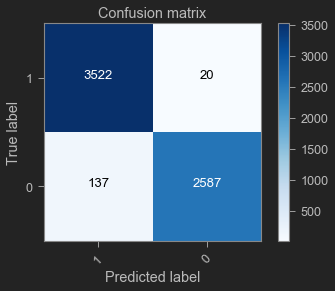

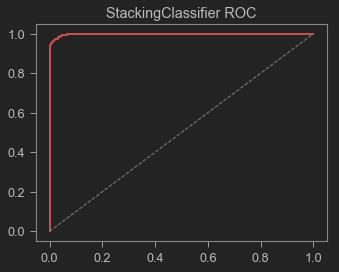

In [82]:
from mlxtend.classifier import StackingClassifier

meta_classifier = LogisticRegression()#.set_params(**LR_best.get_params())
classifiers = [ET_best,RF_best,bagging_xgb,XGB_best,MLP_best,GBDT_best]
# 
# voting_best,
stacking = StackingClassifier(classifiers=classifiers,meta_classifier=meta_classifier,
                             use_probas = True,average_probas=True) #
stacking.fit(train_x,train_y)
train_score = stacking.score(train_x,train_y)
test_score = stacking.score(test_x,test_y)
y_pred = stacking.predict(test_x)
y_pred_prob = stacking.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(stacking,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# GBDT+LR

best score: 0.986467 
 best model: LogisticRegression(C=0.8, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
------LogisticRegression classification_report------
              precision    recall  f1-score   support

          0       0.95      0.99      0.97      3542
          1       0.99      0.93      0.96      2724

avg / total       0.96      0.96      0.96      6266

auc: 0.9867830008847056
train_score: 0.995530964034901 
 test_score: 0.963613150335142


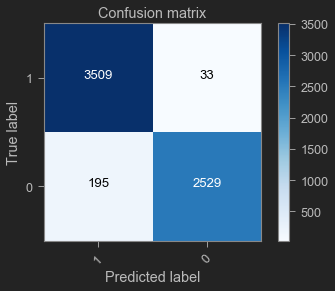

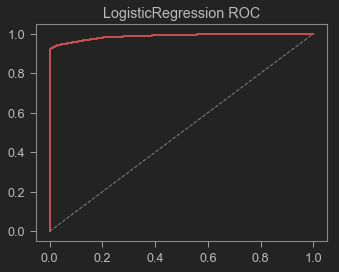

In [79]:
train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y)
train_x,train_x_lr,train_y,train_y_lr = train_test_split(train_x,train_y,stratify=train_y)

from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()

GBDT_best.fit(train_x,train_y)
one_hot.fit(GBDT_best.apply(train_x)[:,:,0])
train_x_lr = one_hot.transform(GBDT_best.apply(train_x_lr)[:,:,0])
test_x_lr = one_hot.transform(GBDT_best.apply(test_x)[:,:,0])
                               
param_grid =  {
            'penalty':['l1'],#'l2'],
            'C':[0.8],
#             'solver':['newton-cg','lbfgs','sag'],#l2
            'solver':['liblinear'],#,'saga',],#l1
            'max_iter':[50],
            'class_weight':['balanced'],
#             'fit_intercept':[True],
            'random_state':[666],      
}

GBLR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='roc_auc')
GBLR.fit(train_x_lr,train_y_lr)

print("best score: %f \n best model: %s" % (GBLR.best_score_, GBLR.best_estimator_))
GBLR_best = GBLR.best_estimator_

train_score = GBLR_best.score(train_x_lr,train_y_lr)
test_score = GBLR_best.score(test_x_lr,test_y)
y_pred = GBLR_best.predict(test_x_lr)
y_pred_prob = GBLR_best.predict_proba(test_x_lr)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(GBLR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

# xgb+lr

[0]	train-auc:0.85961
Will train until train-auc hasn't improved in 304 rounds.
[20]	train-auc:0.941333
[40]	train-auc:0.953764
[60]	train-auc:0.963821
[80]	train-auc:0.970939
[100]	train-auc:0.975219
[120]	train-auc:0.978464
[140]	train-auc:0.981411
[160]	train-auc:0.98347
[180]	train-auc:0.985088
[200]	train-auc:0.986174
[220]	train-auc:0.987126
[240]	train-auc:0.987821
[260]	train-auc:0.988344
[280]	train-auc:0.988761
[300]	train-auc:0.989081
[320]	train-auc:0.989382
[340]	train-auc:0.989627
[360]	train-auc:0.989865
[380]	train-auc:0.990101
[400]	train-auc:0.990315
[420]	train-auc:0.990509
[440]	train-auc:0.990685
[460]	train-auc:0.990847
[480]	train-auc:0.990982
[499]	train-auc:0.991104
best score: 0.990722 
 best model: LogisticRegression(C=0.035, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=666,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=Fals

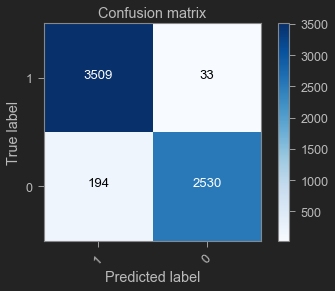

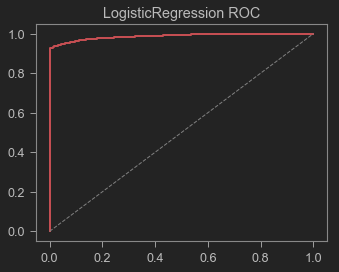

In [81]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

dtrain = xgb.DMatrix(train_x,label=train_y)
dtest = xgb.DMatrix(test_x)
one_hot = OneHotEncoder()

params = {
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
            'eval_metric': 'auc',
            'gamma':0.05,
            'max_depth':3,
            'alpha':7,
            'lambda':5,
            'subsample':0.8,
            'colsample_bytree':0.6,
            'min_child_weight':5, 
            'eta': 0.02,
            'seed':0,
            'silent':1,
            'missing':-1,
        }

xgb_model = xgb.train(params,dtrain,num_boost_round=500,early_stopping_rounds=304,
                       evals=[(dtrain,"train")],verbose_eval=20,maximize=True)

train_leaf = xgb_model.predict(dtrain,ntree_limit=304,pred_leaf=True)
test_leaf = xgb_model.predict(dtest,ntree_limit=304,pred_leaf=True)

train_leaf_hot = one_hot.fit_transform(train_leaf)
test_leaf_hot = one_hot.transform(test_leaf)
     

param_grid =  {
            'penalty':['l2'],
            'C':[0.035],
            'solver':['lbfgs'],#['newton-cg','sag'],#l2
#             'solver':['liblinear'],#,'saga',],#l1
            'max_iter':[100],
            'class_weight':['balanced'],
#             'fit_intercept':[True],
            'random_state':[666],      
}

xgbLR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='roc_auc')
xgbLR.fit(train_leaf_hot,train_y)

print("best score: %f \n best model: %s" % (xgbLR.best_score_,xgbLR.best_estimator_))
xgbLR_best = xgbLR.best_estimator_

train_score = xgbLR_best.score(train_leaf_hot,train_y)
test_score = xgbLR_best.score(test_leaf_hot,test_y)
y_pred = xgbLR_best.predict(test_leaf_hot)
y_pred_prob = xgbLR_best.predict_proba(test_leaf_hot)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(xgbLR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

# FM

In [ ]:
# from fastFM import sgd
# fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
#                               l2_reg_V=0, rank=2, step_size=0.1)
# fm.fit(train_x,train_y)
# y_pred = fm.predict(test_x)
# y_pred_prob = fm.predict_proba(test_x)

# cm = confusion_matrix(test_y,y_pred)

# eval_info(fm,test_y,y_pred_prob,cm)
# print( "train_score:",train_score,"\n","test_score:",test_score)


# LDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {
    'priors':[2], 
    'reg_param':[0.911],
#     'tol':[0.0001]
}


LDA = GridSearchCV(QuadraticDiscriminantAnalysis(),param_grid,cv=sfk,scoring='roc_auc')
LDA.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (LDA.best_score_, LDA.best_estimator_))

LDA_best = LDA.best_estimator_
train_score = LDA_best.score(train_x,train_y)
test_score = LDA_best.score(test_x,test_y)
y_pred = LDA_best.predict(test_x)
y_pred_prob = LDA_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(LDA_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)


In [202]:
# save model
import pickle
with open("./best_models/LDA_pkl.txt",'wb') as f:
    pickle.dump(LDA_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
LDA_cv_auc = cross_val_score(LDA_best,X,y,cv=5,scoring="roc_auc")
print("best_LDA_cv_auc:",LDA_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies par

best_LDA_cv_auc: [0.77966206 0.78624965 0.8102937  0.76345521 0.79018657]


F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# label propagation

In [ ]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised.label_propagation import LabelSpreading

n_total_samples = len(X)
n_labeled_points = 8000
unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
y_train = y.copy()
y_train[unlabeled_indices] = -1

# lp_model = LabelSpreading(kernel='rbf',gamma=0.3,alpha=0.1,max_iter=50)
lp_model = LabelSpreading(kernel='knn',n_neighbors=3,alpha=0.1,max_iter=50)
lp_model.fit(X, y_train)

print("------------------标签传播评估----------------------")
predicted_labels = lp_model.transduction_[unlabeled_indices]
true_labels = y[unlabeled_indices]
cm = confusion_matrix(true_labels, predicted_labels)

print(classification_report(true_labels, predicted_labels))
print("-----true labels of unlabeled y:-----\n",true_labels.value_counts())
print("-----predict labels of unlabeled y:-----\n",pd.Series(predicted_labels).value_counts())
plot_confusion_matrix(cm,classes=y.unique())

# PCA

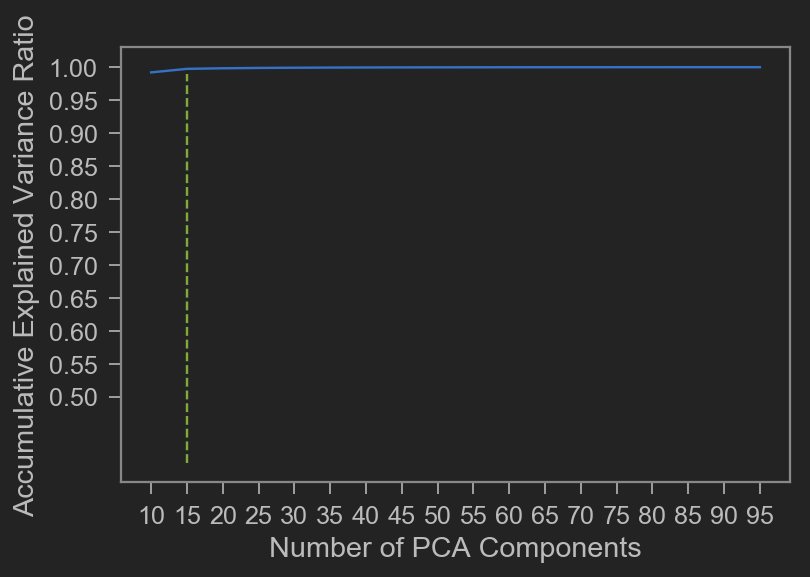

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
n_components = range(10,100,5)
acc_explained_ratio = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(X)
    acc_explained_ratio.append(np.sum(pca.explained_variance_ratio_))
plt.figure(figsize=(6,4),dpi=144)
plt.plot(n_components,acc_explained_ratio)
plt.xlabel("Number of PCA Components")
plt.ylabel("Accumulative Explained Variance Ratio")
plt.yticks(np.arange(0.5,1.05,0.05))
plt.xticks(np.arange(0,100,5))
plt.plot((15,15),(0.4,0.99),"g--")
plt.show()

In [39]:
n_components = 15
pca_model = PCA(n_components=n_components).fit(train_x)
pca_train_x = pca_model.transform(train_x)
pca_test_x = pca_model.transform(test_x)
param_grid = {"C":[1,5,10,50],"gamma":[0.0001,0.0005,0.001,0.005,0.01],
              "kernel":["rbf"],"class_weight":["balanced"]}
SVC_PCA_model = GridSearchCV(SVC(),param_grid,verbose=2,n_jobs=4)
SVC_PCA_model.fit(pca_train_x,train_y)
print("-----SVM Classifier(PCA)------\n",
      "best param:{0}\nbest score:{1}".format(SVC_PCA_model.best_params_,SVC_PCA_model.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.5min finished


-----SVM Classifier(PCA)------
 best param:{'C': 50, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
best score:0.79575


In [41]:
y_pred = SVC_PCA_model.best_estimator_.predict(pca_test_x)
print("------Confusion Matrix------\n",confusion_matrix(test_y,y_pred))
print("-----Classification_report-----\n",classification_report(test_y,y_pred))

------Confusion Matrix------
 [[2281  585]
 [  78   56]]
-----Classification_report-----
              precision    recall  f1-score   support

          0       0.97      0.80      0.87      2866
          1       0.09      0.42      0.14       134

avg / total       0.93      0.78      0.84      3000



# K-Means

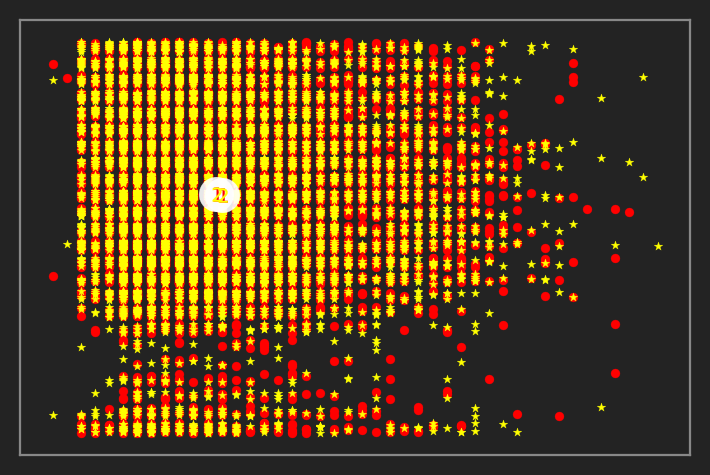

In [39]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2)
kmean.fit(X)
kmean_score = kmean.score(X)

labels = kmean.labels_
centers = kmean.cluster_centers_
plt.figure(figsize=(6,4),dpi=144)
plt.xticks(())
plt.yticks(())
plt.scatter(X[labels==0].iloc[:,0],X[labels==0].iloc[:,1],marker="o",s=20,c="red")
plt.scatter(X[labels==1].iloc[:,0],X[labels==1].iloc[:,1],marker="*",s=20,c="yellow")
plt.scatter(centers[:,0],centers[:,1],marker="o",c="white",alpha=0.9,s=300)
plt.scatter(centers[:,0],centers[:,1],marker="$1$",c="red",s=50)
plt.scatter(centers[:,0],centers[:,1],marker="$2$",c="yellow",s=50)

In [40]:
from sklearn.metrics import adjusted_rand_score,homogeneity_score,completeness_score,v_measure_score
AR_score = adjusted_rand_score(y,labels)
H_score = homogeneity_score(y,labels)
C_score = completeness_score(y,labels)
V_score = v_measure_score(y,labels)
print("Adjusted Rand-Index:",AR_score,"\n",
     "Homogeneity Score:",H_score,"\n",
     "Completeness Score:",C_score,"\n",
     "V-measure Score:",V_score)

Adjusted Rand-Index: 0.0027599712496652125 
 Homogeneity Score: 0.01662842545061333 
 Completeness Score: 0.004487396252852615 
 V-measure Score: 0.0070675283307278045


# KNN

------KNeighborsClassifier------
elaspe: 305.2950389313734 
 train_score: 0.9540508947037137 
 test_score: 0.9538834951456311
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.00      0.00      0.00       171

avg / total       0.91      0.95      0.93      3708

auc: 0.5
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3537    0]
 [ 171    0]]


F:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------KNeighborsClassifier------
elaspe: 305.5213248479308 
 train_score: 1.0 
 test_score: 0.953344120819849
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.25      0.01      0.01       171

avg / total       0.92      0.95      0.93      3708

auc: 0.5024998883978394
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3534    3]
 [ 170    1]]
------RadiusNeighborsClassifier------
elaspe: 436.63880084495827 
 train_score: 0.9538710547612624 
 test_score: 0.9538834951456311
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.00      0.00      0.00       171

avg / total       0.91      0.95      0.93      3708

auc: 0.5
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3537    0]
 [ 171    0]]


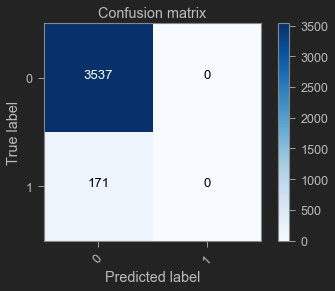

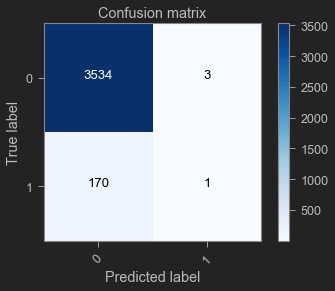

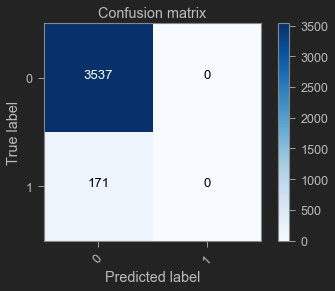

In [29]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
knn_model1 = KNeighborsClassifier(n_neighbors=10)
knn_model2 = KNeighborsClassifier(n_neighbors=10,weights="distance")
knn_model3 = RadiusNeighborsClassifier(n_neighbors=10,radius=1000.0)

models = [knn_model1,knn_model2,knn_model3]
for knn in models:
    start = time.clock()
    knn.fit(train_x,train_y)
    train_score = knn.score(train_x,train_y)
    test_score = knn.score(test_x,test_y)
    y_pred = knn.predict(test_x)
    print("------"+knn.__class__.__name__+"------\n"
          "elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
    cm = confusion_matrix(test_y,y_pred)
    eval_info(test_y,y_pred,y_score,cm)

# naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB
import time

GNB = GaussianNB()
BNB = BernoulliNB()
# models = [GNB,BNB]
# for NB in models:
start = time.clock()
GNB.fit(train_x,train_y)
train_score = GNB.score(train_x,train_y)
test_score = GNB.score(test_x,test_y)
print("elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
# y_pred = GNB.predict(test_x)
y_pred_prob1 = GNB.predict_proba(test_x)[:,1]

start = time.clock()
BNB.fit(train_x,train_y)
train_score = BNB.score(train_x,train_y)
test_score = BNB.score(test_x,test_y)
print("elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
# y_pred = GNB.predict(test_x)
y_pred_prob2 = BNB.predict_proba(test_x)[:,1]

y_pred_prob = y_pred_prob1 + y_pred_prob2
y_pred = np.where(y_pred_prob>0.5,1,0)

cm = confusion_matrix(test_y,y_pred)
eval_info(NB,test_y,y_pred_prob,cm)